라이브러리

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

원시데이터 준비

In [3]:
CSV_PATH = 'stock_daily.csv'

df = pd.read_csv(CSV_PATH, parse_dates=['date'])
df['return'] = df['close'].pct_change() # 이전 데이터 대비 변화율 계산
# [100,110,99] => [nan, 0.1, -0.1]
df['roll_mean_5'] = df['close'].rolling(5).mean() # 현재를 포함하여 이전 5개 데이터의 평균계산
df['roll_mean_20'] = df['close'].rolling(20).mean()
df

,date,close,volume,return,roll_mean_5,roll_mean_20
0,2019-01-01,96.45,631737,NaN,NaN,NaN
1,2019-01-02,100.42,747488,0.041161,NaN,NaN
2,2019-01-03,99.90,632070,-0.005178,NaN,NaN
3,2019-01-04,99.34,804880,-0.005606,NaN,NaN
4,2019-01-07,97.61,752796,-0.017415,98.744,NaN
...,...,...,...,...,...,...
595,2021-04-13,208.60,828040,-0.014597,209.050,209.0255
596,2021-04-14,208.84,605206,0.001151,209.158,208.9695
597,2021-04-15,206.10,558111,-0.013120,209.126,208.8025
598,2021-04-16,210.31,586121,0.020427,209.108,208.9855


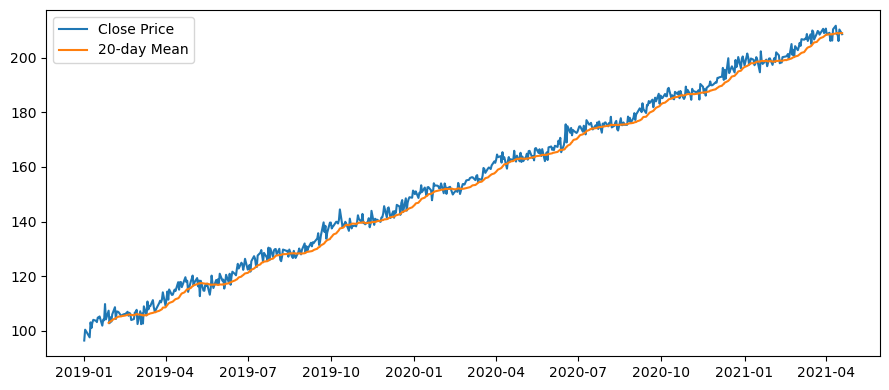

In [4]:
# 추세 시각화
plt.figure(figsize=(9,4))
plt.plot(df['date'], df['close'], label='Close Price')
plt.plot(df['date'], df['roll_mean_20'], label='20-day Mean')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
df['dow'] = df['date'].dt.dayofweek # 0:월,1:화,2:수,3:목,4:금
df['month'] = df['date'].dt.month

df['ret_1'] = df['close'].pct_change(1) # 전날대비 증가율 (=return칼럼이랑 같음)
df['ret_5'] = df['close'].pct_change(5) # 5일전 대비 증가율

df.tail()

,date,close,volume,return,roll_mean_5,roll_mean_20,dow,month,ret_1,ret_5
595,2021-04-13,208.60,828040,-0.014597,209.050,209.0255,1,4,-0.014597,0.011835
596,2021-04-14,208.84,605206,0.001151,209.158,208.9695,2,4,0.001151,0.002592
597,2021-04-15,206.10,558111,-0.013120,209.126,208.8025,3,4,-0.013120,-0.000776
598,2021-04-16,210.31,586121,0.020427,209.108,208.9855,4,4,0.020427,-0.000428
599,2021-04-19,208.59,769787,-0.008178,208.488,208.9735,0,4,-0.008178,-0.014644


In [6]:
# 이전 데이터들을 가로로 보기 위해 칼럼 추가
LAGS = [1,2,3,4,5]
for i in LAGS:
    df[f'close_lag{i}'] = df['close'].shift(i)
df.tail()

,date,close,volume,return,roll_mean_5,roll_mean_20,dow,month,ret_1,ret_5,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5
595,2021-04-13,208.60,828040,-0.014597,209.050,209.0255,1,4,-0.014597,0.011835,211.69,210.40,206.26,208.30,206.16
596,2021-04-14,208.84,605206,0.001151,209.158,208.9695,2,4,0.001151,0.002592,208.60,211.69,210.40,206.26,208.30
597,2021-04-15,206.10,558111,-0.013120,209.126,208.8025,3,4,-0.013120,-0.000776,208.84,208.60,211.69,210.40,206.26
598,2021-04-16,210.31,586121,0.020427,209.108,208.9855,4,4,0.020427,-0.000428,206.10,208.84,208.60,211.69,210.40
599,2021-04-19,208.59,769787,-0.008178,208.488,208.9735,0,4,-0.008178,-0.014644,210.31,206.10,208.84,208.60,211.69


In [7]:
# 현재를 제외하고 이전 데이터들 활용
df['roll_mean_5'] = df['close'].rolling(5).mean().shift(1)
df['roll_std_5'] = df['close'].rolling(5).std().shift(1)
df['roll_mean_20'] = df['close'].rolling(20).mean().shift(1)

df['log_vol'] = np.log1p(df['volume']) # 숫자가 너무 커서 비교가 어려움. log(1+x)
# 1을 더해주는 이유는 log0은 -inf이므로 안전하게 값을 처리하기 위함
df['val_roll_mean_5'] = df['log_vol'].rolling(5).mean().shift(1)
df.tail()

,date,close,volume,return,roll_mean_5,roll_mean_20,dow,month,ret_1,ret_5,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,roll_std_5,log_vol,val_roll_mean_5
595,2021-04-13,208.60,828040,-0.014597,208.562,208.8440,1,4,-0.014597,0.011835,211.69,210.40,206.26,208.30,206.16,2.464756,13.626818,13.464725
596,2021-04-14,208.84,605206,0.001151,209.050,209.0255,2,4,0.001151,0.002592,208.60,211.69,210.40,206.26,208.30,2.082138,13.313326,13.505266
597,2021-04-15,206.10,558111,-0.013120,209.158,208.9695,3,4,-0.013120,-0.000776,208.84,208.60,211.69,210.40,206.26,2.047223,13.232315,13.490740
598,2021-04-16,210.31,586121,0.020427,209.126,208.8025,4,4,0.020427,-0.000428,206.10,208.84,208.60,211.69,210.40,2.104300,13.281283,13.472244
599,2021-04-19,208.59,769787,-0.008178,209.108,208.9855,0,4,-0.008178,-0.014644,210.31,206.10,208.84,208.60,211.69,2.091021,13.553870,13.416407


In [8]:
df['target_next'] = df['close'].shift(-1)
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             579 non-null    datetime64[ns]
 1   close            579 non-null    float64       
 2   volume           579 non-null    int64         
 3   return           579 non-null    float64       
 4   roll_mean_5      579 non-null    float64       
 5   roll_mean_20     579 non-null    float64       
 6   dow              579 non-null    int32         
 7   month            579 non-null    int32         
 8   ret_1            579 non-null    float64       
 9   ret_5            579 non-null    float64       
 10  close_lag1       579 non-null    float64       
 11  close_lag2       579 non-null    float64       
 12  close_lag3       579 non-null    float64       
 13  close_lag4       579 non-null    float64       
 14  close_lag5       579 non-null    float64  

In [9]:
feature_cols = [ c for c in df.columns if c not in ['date','close','target_next']]
cut = int(len(df) * 0.8) # train/test 셋을 나누는 기준선

train, valid = df.iloc[:cut].copy(), df.iloc[cut:].copy()

X_tr, y_tr = train[feature_cols], train['target_next']
X_va, y_va = valid[feature_cols], valid['target_next']
(len(X_tr), len(X_va))

(463, 116)

In [10]:
# Symmetric Mean Absolute Percentage Error, 대칭 평균 절대 백분율 오차
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1e-9, denom) # 0이면 나누기 연산 시 오류 날 수 있으므로 1e-9로 조정
    return 100 * np.mean(np.abs(y_true - y_pred) / denom)

In [11]:
yhat_naive = valid['close'].values # 오늘 종가를 예측값으로 봄.
# 즉, 내일의 종가는 오늘의 종가와 같을 것이다라고 예측한 상황 (naive한 상황)
mae_naive = mean_absolute_error(y_va, yhat_naive)
rmse_naive = np.sqrt(mean_squared_error(y_va, yhat_naive))
smape_naive = smape(y_va, yhat_naive)

print(f'BaseLine - Naive : MAE = {mae_naive:.4f}, RMSE = {rmse_naive:.4f}, sMAPE = {smape_naive:.4f}%')
# MAE = 1.9423, RMSE = 2.4925, sMAPE = 0.4865%
# 예측의 차이가 0.4865% 정도 밖에 나지 않으므로 성능이 나쁘지 않음.

BaseLine - Naive : MAE = 1.9423, RMSE = 2.4925, sMAPE = 0.4865%


In [12]:
shift_k = 5
yhat_seas = valid['close'].shift(1-shift_k) # 4일 후의 종가를 내일의 종가로 예측
# 월->금,화->월,수->화,목->수,금->목

mask = ~yhat_seas.isna() # 마지막 4개의 데이터가 4일 후의 데이터가 없으니 결측치로 저장되어있음.
# print(mask)
mae_seas = mean_absolute_error(y_va[mask], yhat_seas[mask])
rmse_seas = np.sqrt(mean_squared_error(y_va[mask], yhat_seas[mask]))
smape_seas = smape(y_va[mask], yhat_seas[mask])

print(f'BaseLine - Seas : MAE = {mae_seas:.4f}, RMSE = {rmse_seas:.4f}, sMAPE = {smape_seas:.4f}%')

BaseLine - Seas : MAE = 1.8900, RMSE = 2.3569, sMAPE = 0.4739%


In [15]:
# 4일전 데이터로 예측하려고 하는데 그럼 valid 셋에서 4개의 데이터가 결측치가 생김
# 이 결측치는 훈련데이터셋에서 채울 수 있으니 concat 한 후 채우고 다시 나누기
hist = pd.concat([train['close'],valid['close']])
pred_seas_all = hist.shift(shift_k-1) # 4일전 데이터로 예측하기
pred_seas_aligned = pred_seas_all.loc[valid.index] # valid 셋만

mae_seas = mean_absolute_error(y_va, pred_seas_aligned)
rmse_seas = np.sqrt(mean_squared_error(y_va, pred_seas_aligned))
smape_seas = smape(y_va, pred_seas_aligned)

print(f'BaseLine - Seas : MAE = {mae_seas:.4f}, RMSE = {rmse_seas:.4f}, sMAPE = {smape_seas:.4f}%')

BaseLine - Seas : MAE = 2.1524, RMSE = 2.6214, sMAPE = 0.5408%
